In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load datasets
vix_df = pd.read_csv("./CBOE VIX.csv")
sharpe_ratios_df = pd.read_csv("./Sharpe Ratios for S&P 500 Co.csv")
risk_ratings_df = pd.read_csv("./SP 500 ESG Risk Ratings.csv")

In [3]:
sharpe_ratios_df = sharpe_ratios_df.loc[:, ~sharpe_ratios_df.columns.str.contains('^Unnamed')]

sharpe_ratios_df.dropna(how='all', inplace=True)
risk_ratings_df.dropna(how='all', inplace=True)
sharpe_ratios_df = sharpe_ratios_df[~sharpe_ratios_df['Name'].astype(str).str.contains(r'^\t|\n$', na=False)]
risk_ratings_df = risk_ratings_df[~risk_ratings_df['Name'].astype(str).str.contains(r'^\t|\n$', na=False)]

In [4]:
# Convert to datetime values
vix_df['Date'] = pd.to_datetime(vix_df['Date']).dt.to_period('M')
vix_df = vix_df[['Date', 'Close']]

# Convert the date columns to specific dates in the date column
sharpe_ratios_long = sharpe_ratios_df.melt(
    id_vars=['Symbol', 'Name', 'Metrics'], 
    var_name='Date', 
    value_name='Sharpe Ratio'
)
sharpe_ratios_long['Date'] = pd.to_datetime(sharpe_ratios_long['Date'], format='%b %y', errors='coerce').dt.to_period('M')
sharpe_ratios_long = sharpe_ratios_long.dropna(subset=['Date'])

C:\Users\ojasv\AppData\Local\Temp\ipykernel_48944\2969627071.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  vix_df['Date'] = pd.to_datetime(vix_df['Date']).dt.to_period('M')


In [7]:
# Merge Sharpe Ratios with ESG Risk Ratings
merged_data = sharpe_ratios_long.merge(risk_ratings_df, on="Symbol", how="left")

# Merge with VIX data
final_timeseries = merged_data.merge(vix_df, on="Date", how="left")

In [13]:
cols = ["Symbol", "Name_x", "Metrics", "Date", "Sharpe Ratio", "Sector", "Close", "Environment Risk Score"]
final_timeseries = final_timeseries[cols]

In [14]:
final_timeseries

,Symbol,Name_x,Metrics,Date,Sharpe Ratio,Sector,Close,Environment Risk Score
0,A,Agilent Technologies Inc,Historical Sharpe Ratio (Since Inception),2023-05,0.1307,Healthcare,17.95,1.1
1,AAPL,Apple Inc,Historical Sharpe Ratio (Since Inception),2023-05,0.3859,Technology,17.95,0.5
2,ABBV,AbbVie Inc,Historical Sharpe Ratio (Since Inception),2023-05,0.7112,Healthcare,17.95,2.4
3,ABNB,Airbnb Inc,Historical Sharpe Ratio (Since Inception),2023-05,-0.2592,Consumer Cyclical,17.95,NaN
4,ABT,Abbott Laboratories,Historical Sharpe Ratio (Since Inception),2023-05,0.5981,Healthcare,17.95,2.3
...,...,...,...,...,...,...,...,...
11083,XYL,Xylem Inc,Historical Sharpe Ratio (Since Inception),2020-05,0.5270,Industrials,27.51,4.3
11084,YUM,Yum Brands Inc,Historical Sharpe Ratio (Since Inception),2020-05,0.4917,Consumer Cyclical,27.51,4.5
11085,ZBH,Zimmer Biomet Holdings Inc,Historical Sharpe Ratio (Since Inception),2020-05,0.2707,Healthcare,27.51,3.6
11086,ZBRA,Zebra Technologies Corp,Historical Sharpe Ratio (Since Inception),2020-05,0.3729,Technology,27.51,NaN


In [29]:
aggregated_timeseries = final_timeseries.groupby('Date').agg({
    'Sharpe Ratio': 'mean',
    'Close': 'mean',
    'Environment Risk Score': 'mean'
}).reset_index()
aggregated_timeseries.dtypes

Date                       object
Sharpe Ratio              float64
Close                     float64
Environment Risk Score    float64
dtype: object

In [26]:
# Convert numeric columns to float for proper plotting
aggregated_timeseries['Date'] = aggregated_timeseries['Date'].astype(str)
final_timeseries['Date'] = final_timeseries['Date'].astype(str)


C:\Users\ojasv\AppData\Local\Temp\ipykernel_48944\41134571.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_timeseries['Date'] = final_timeseries['Date'].astype(str)


## EDA

In [37]:
print( final_timeseries.describe())

       Sharpe Ratio         Close  Environment Risk Score
count  10923.000000  11088.000000             9262.000000
mean       0.437227     23.792273                5.719002
std        2.560209      5.586086                5.034541
min       -2.886000     16.260000                0.000000
25%        0.261250     19.400000                1.800000
50%        0.379100     23.790000                4.100000
75%        0.495900     27.190000                8.800000
max      260.070000     38.020000               25.000000


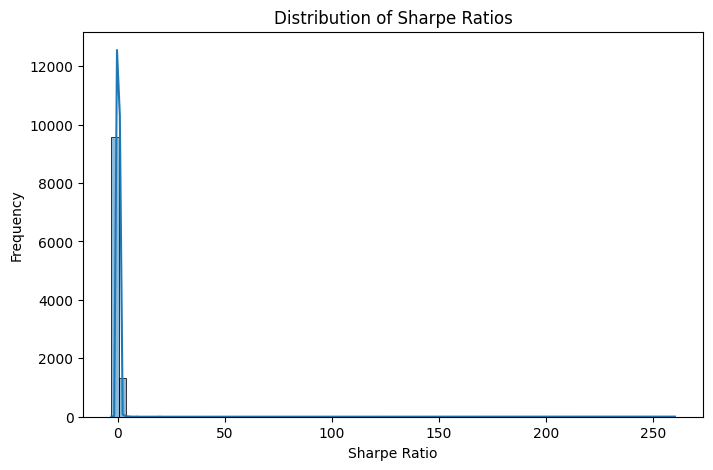

In [44]:
plt.figure(figsize=(8, 5))
sns.histplot(final_timeseries["Sharpe Ratio"], bins=75, kde=True)
plt.title("Distribution of Sharpe Ratios")
plt.xlabel("Sharpe Ratio")
plt.ylabel("Frequency")
plt.show()

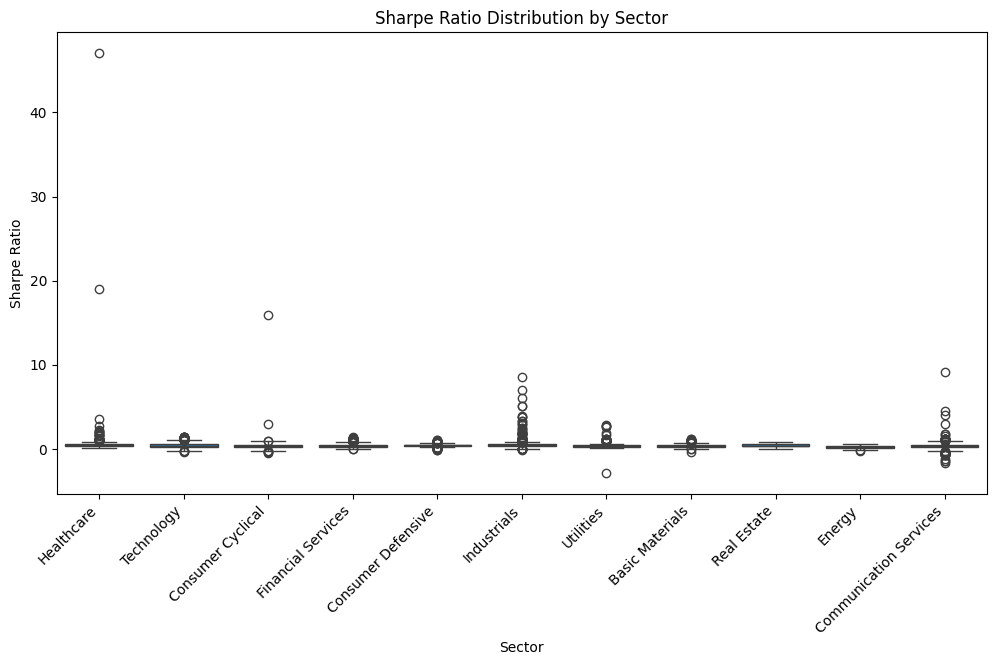

In [45]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=final_timeseries, x="Sector", y="Sharpe Ratio")
plt.xticks(rotation=45, ha="right")
plt.title("Sharpe Ratio Distribution by Sector")
plt.show()

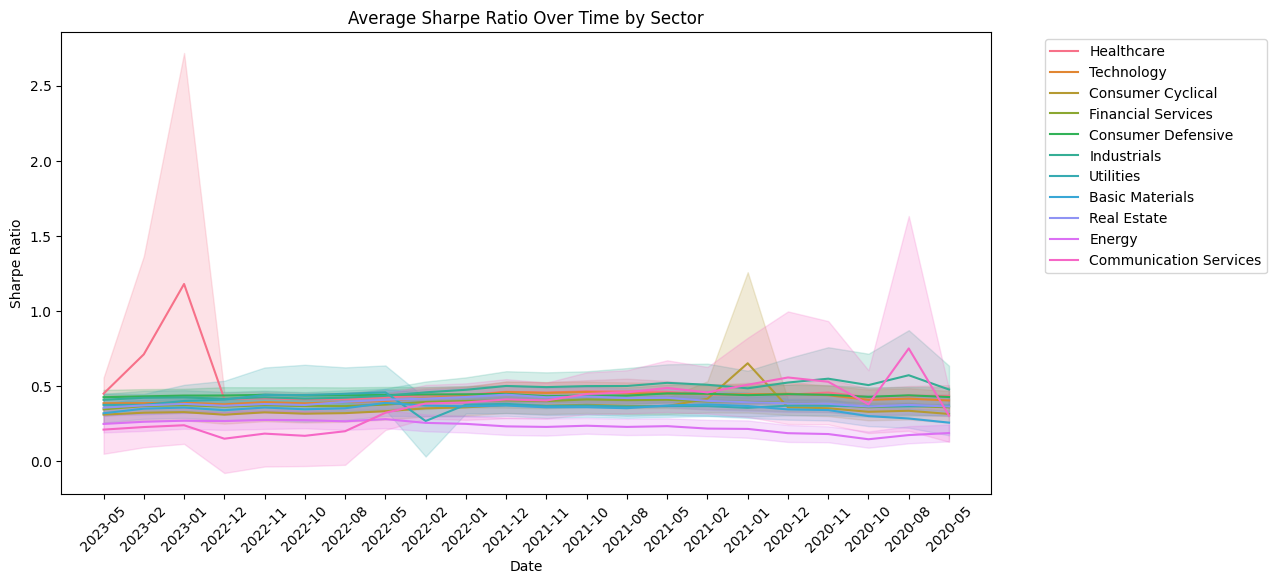

In [46]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=final_timeseries, x="Date", y="Sharpe Ratio", hue="Sector", estimator="mean")
plt.xticks(rotation=45)
plt.title("Average Sharpe Ratio Over Time by Sector")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()

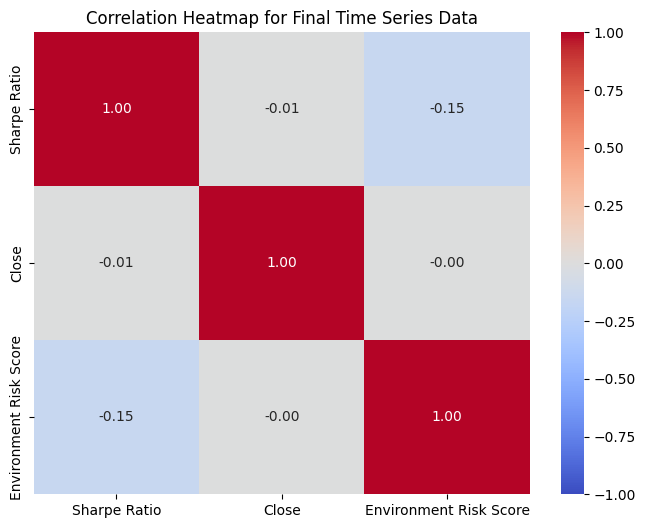

In [50]:
plt.figure(figsize=(8, 6))
sns.heatmap(final_timeseries.corr(numeric_only=True), annot=True, cmap="coolwarm", fmt=".2f", vmin=-1, vmax=1)
plt.title("Correlation Heatmap for Final Time Series Data")
plt.show()

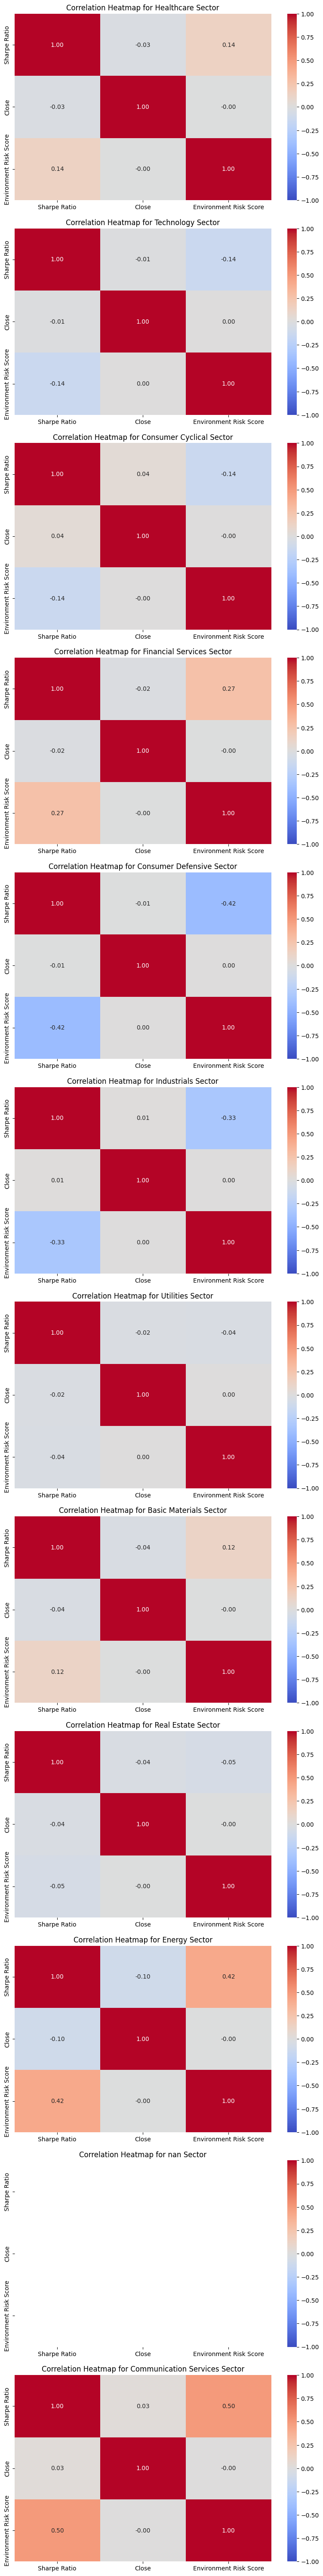

In [51]:
sector_list = final_timeseries["Sector"].unique()
fig, axes = plt.subplots(nrows=len(sector_list), figsize=(8, len(sector_list) * 5))
for i, sector in enumerate(sector_list):
    sector_data = final_timeseries[final_timeseries["Sector"] == sector]

    corr_matrix = sector_data[["Sharpe Ratio", "Close", "Environment Risk Score"]].corr(numeric_only=True)

    sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", ax=axes[i], vmin=-1, vmax=1)
    axes[i].set_title(f"Correlation Heatmap for {sector} Sector")

plt.tight_layout()
plt.show()

In [36]:
print(aggregated_timeseries.describe())

       Sharpe Ratio      Close  Environment Risk Score
count     22.000000  22.000000            2.200000e+01
mean       0.437323  23.792273            5.719002e+00
std        0.118236   5.717284            9.090796e-16
min        0.367874  16.260000            5.719002e+00
25%        0.384036  19.692500            5.719002e+00
50%        0.419259  23.790000            5.719002e+00
75%        0.433704  26.995000            5.719002e+00
max        0.948431  38.020000            5.719002e+00


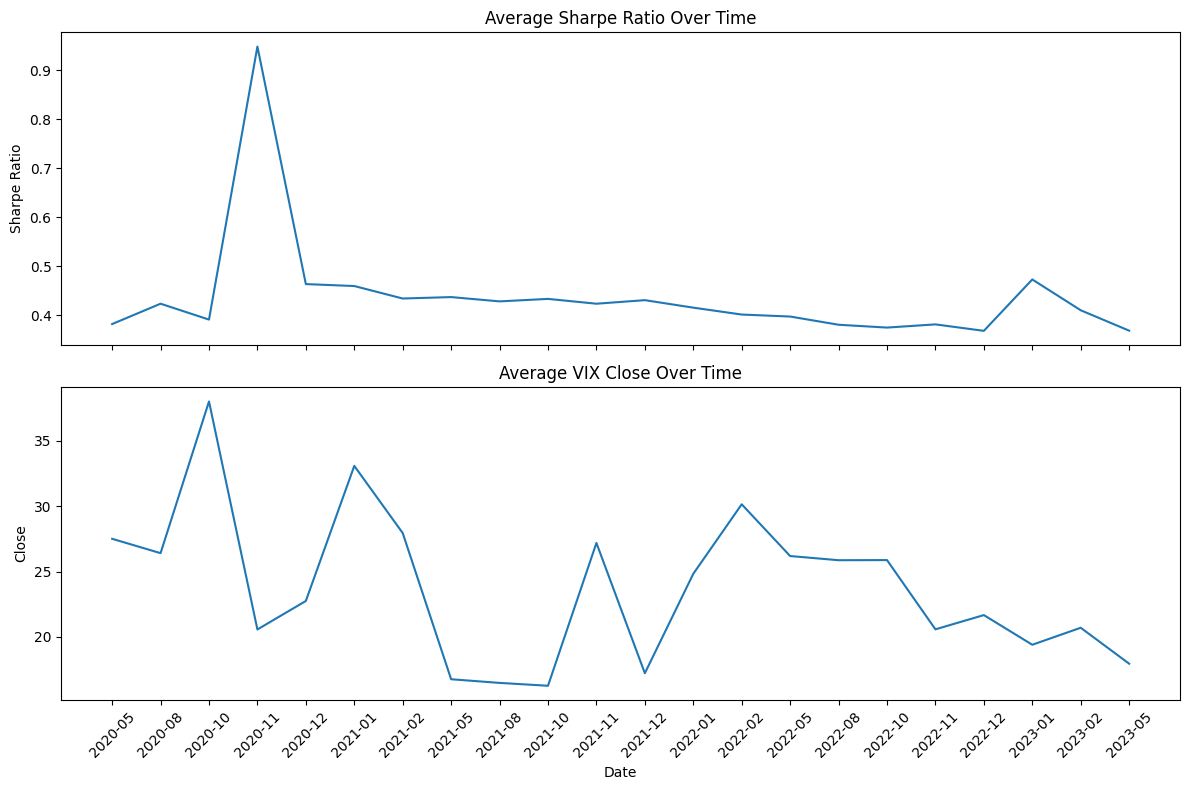

In [31]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 8), sharex=True)

sns.lineplot(data=aggregated_timeseries, x="Date", y="Sharpe Ratio", ax=axes[0])
axes[0].set_title("Average Sharpe Ratio Over Time")

# VIX Close Trend
sns.lineplot(data=aggregated_timeseries, x="Date", y="Close", ax=axes[1])
axes[1].set_title("Average VIX Close Over Time")

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

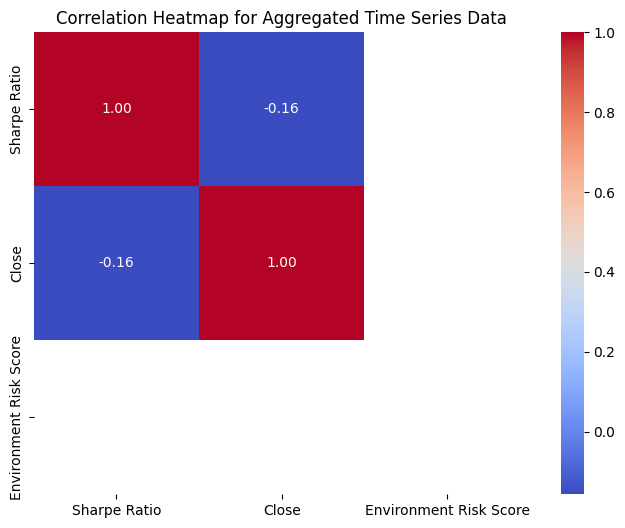

In [34]:
plt.figure(figsize=(8, 6))
sns.heatmap(aggregated_timeseries.corr(numeric_only=True), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap for Aggregated Time Series Data")
plt.show()